In [ ]:
import time
import gc
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch import nn
import torchvision
import torch

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [ ]:
class GLU(nn.Module):
    """
      The Gated Linear Unit GLU(a,b) = mult(a,sigmoid(b)) is common in NLP
      architectures like the Gated CNN. Here sigmoid(b) corresponds to a gate
      that controls what information from a is passed to the following layer.

      Args:
          input_size (int): number defining input and output size of the gate
    """
    def __init__(self, input_size):
        super().__init__()

        # Input
        self.a = nn.Linear(input_size, input_size)

        # Gate
        self.sigmoid = nn.Sigmoid()
        self.b = nn.Linear(input_size, input_size)

    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor passing through the gate
        """
        gate = self.sigmoid(self.b(x))
        x = self.a(x)

        return torch.mul(gate, x)

In [ ]:
class TemporalLayer(nn.Module):
    def __init__(self, module):
        super().__init__()
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.

        Similar to TimeDistributed in Keras, it is a wrapper that makes it possible
        to apply a layer to every temporal slice of an input.
        """
        self.module = module


    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor with time steps to pass through the same layer.
        """
        t, n = x.size(0), x.size(1)
        x = x.reshape(t * n, -1)
        x = self.module(x)
        x = x.reshape(t, n, x.size(-1))

        return x

In [ ]:
class GatedResidualNetwork(nn.Module):
    """
      The Gated Residual Network gives the model flexibility to apply non-linear
      processing only when needed. It is difficult to know beforehand which
      variables are relevant and in some cases simpler models can be beneficial.

      GRN(a, c) = LayerNorm(a + GLU(eta_1)) # Dropout is applied to eta_1
        eta_1 = W_1*eta_2 + b_1
        eta_2 = ELU(W_2*a + W_3*c + b_2)

      Args:
          input_size (int): Size of the input
          hidden_size (int): Size of the hidden layer
          output_size (int): Size of the output layer
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
          context_size (int): Size of the static context vector
          is_temporal (bool): Flag to decide if TemporalLayer has to be used or not
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, context_size=None, is_temporal=True):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.is_temporal = is_temporal

        if self.is_temporal:
            if self.input_size != self.output_size:
                self.skip_layer = TemporalLayer(nn.Linear(self.input_size, self.output_size))

            # Context vector c
            if self.context_size != None:
                self.c = TemporalLayer(nn.Linear(self.context_size, self.hidden_size, bias=False))

            # Dense & ELU
            self.dense1 = TemporalLayer(nn.Linear(self.input_size, self.hidden_size))
            self.elu = nn.ELU()

            # Dense & Dropout
            self.dense2 = TemporalLayer(nn.Linear(self.hidden_size,  self.output_size))
            self.dropout = nn.Dropout(self.dropout)

            # Gate, Add & Norm
            self.gate = TemporalLayer(GLU(self.output_size))
            self.layer_norm = TemporalLayer(nn.LayerNorm(self.output_size))

        else:
            if self.input_size != self.output_size:
                self.skip_layer = nn.Linear(self.input_size, self.output_size)

            # Context vector c
            if self.context_size != None:
                self.c = nn.Linear(self.context_size, self.hidden_size, bias=False)

            # Dense & ELU
            self.dense1 = nn.Linear(self.input_size, self.hidden_size)
            self.elu = nn.ELU()

            # Dense & Dropout
            self.dense2 = nn.Linear(self.hidden_size,  self.output_size)
            self.dropout = nn.Dropout(self.dropout)

            # Gate, Add & Norm
            self.gate = GLU(self.output_size)
            self.layer_norm = nn.LayerNorm(self.output_size)


    def forward(self, x, c=None):
        """
        Args:
            x (torch.tensor): tensor thas passes through the GRN
            c (torch.tensor): Optional static context vector
        """

        if self.input_size!=self.output_size:
            a = self.skip_layer(x)
        else:
            a = x

        x = self.dense1(x)

        if c != None:
            c = self.c(c.unsqueeze(1))
            x += c

        eta_2 = self.elu(x)

        eta_1 = self.dense2(eta_2)
        eta_1 = self.dropout(eta_1)

        gate = self.gate(eta_1)
        gate += a
        x = self.layer_norm(gate)

        return x

In [ ]:
class VariableSelectionNetwork(nn.Module):
    """
      The Variable Selection Network gives the model the ability to remove
      unnecessary noisy inputs that could have a negative impact on performance.
      It also allows us to better understand which variables are most important
      for the prediction task.

      The variable selection weights are created by feeding both the flattened
      vector of all past inputs at time t (E_t) and an optional context vector
      through a GRN, followed by a Softmax layer.

      V_xt = Softmax(GRN_v(E_t, c_s))

      Also, the feature vector for each variable is fed through its
      own GRN to create an additional layer of non-linear processing.

      Processed features are then weighted by the variable selection weights
      and combined.

      Args:
          input_size (int): Size of the input
          output_size (int): Size of the output layer
          hidden_size (int): Size of the hidden layer
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
          context_size (int): Size of the static context vector
          is_temporal (bool): Flag to decide if TemporalLayer has to be used or not
    """
    def __init__(self, input_size, output_size, hidden_size, dropout, context_size=None, is_temporal=True):
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = dropout
        self.context_size = context_size
        self.is_temporal = is_temporal

        self.flattened_inputs = GatedResidualNetwork(self.output_size*self.input_size,
                                                     self.hidden_size, self.output_size,
                                                     self.dropout, self.context_size,
                                                     self.is_temporal)

        self.transformed_inputs = nn.ModuleList(
            [GatedResidualNetwork(
                self.input_size, self.hidden_size, self.hidden_size,
                self.dropout, self.context_size, self.is_temporal) for i in range(self.output_size)])

        self.softmax = nn.Softmax(dim=-1)


    def forward(self, embedding, context=None):
        """
        Args:
          embedding (torch.tensor): Entity embeddings for categorical variables and linear
                     transformations for continuous variables.
          context (torch.tensor): The context is obtained from a static covariate encoder and
                   is naturally omitted for static variables as they already
                   have access to this
        """

        # Generation of variable selection weights
        sparse_weights = self.flattened_inputs(embedding, context)
        if self.is_temporal:
            sparse_weights = self.softmax(sparse_weights).unsqueeze(2)
        else:
            sparse_weights = self.softmax(sparse_weights).unsqueeze(1)

        # Additional non-linear processing for each feature vector
        transformed_embeddings = torch.stack(
            [self.transformed_inputs[i](embedding[
                Ellipsis, i*self.input_size:(i+1)*self.input_size]) for i in range(self.output_size)], axis=-1)

        # Processed features are weighted by their corresponding weights and combined
        combined = transformed_embeddings*sparse_weights
        combined = combined.sum(axis=-1)

        return combined, sparse_weights

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """
    Attention mechansims usually scale values based on relationships between
    keys and queries.

    Attention(Q,K,V) = A(Q,K)*V where A() is a normalization function.

    A common choice for the normalization function is scaled dot-product attention:

    A(Q,K) = Softmax(Q*K^T / sqrt(d_attention))

    Args:
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
    """
    def __init__(self, dropout=0.0):
        super().__init__()

        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=2)


    def forward(self, query, key, value, mask=None):
        """
        Args:
          query (torch.tensor):
          key (torch.tensor):
          value (torch.tensor):
          mask (torch.tensor):
        """

        d_k = key.shape[-1]
        scaling_factor = torch.sqrt(torch.tensor(d_k).to(torch.float32))

        scaled_dot_product = torch.matmul(query, key.permute(0,2,1)) / scaling_factor
        if mask != None:
            scaled_dot_product = scaled_dot_product.masked_fill(mask == 0, -1e9)
        attention = self.softmax(scaled_dot_product)
        attention = self.dropout(attention)
        output = torch.matmul(attention, value)

        return output, attention

In [ ]:
class InterpretableMultiHeadAttention(nn.Module):
    """
    Different attention heads can be used to improve the learning capacity of
    the model.

    MultiHead(Q,K,V) = [H_1, ..., H_m]*W_H
    H_h = Attention(Q*Wh_Q, K*Wh_K, V*Wh_V)

    Each head has specific weights for keys, queries and values. W_H linearly
    combines the concatenated outputs from all heads.

    To increase interpretability, multi-head attention has been modified to share
    values in each head.

    InterpretableMultiHead(Q,K,V) = H_I*W_H
    H_I = 1/H * SUM(Attention(Q*Wh_Q, K*Wh_K, V*W_V)) # Note that W_V does not depend on the head.

    Args:
          num_heads (int): Number of attention heads
          hidden_size (int): Hidden size of the model
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
    """
    def __init__(self, num_attention_heads, hidden_size, dropout=0.0):
        super().__init__()

        self.num_attention_heads = num_attention_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)

        self.qs = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size, bias=False) for i in range(self.num_attention_heads)])
        self.ks = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size, bias=False) for i in range(self.num_attention_heads)])

        vs_layer = nn.Linear(self.hidden_size, self.hidden_size, bias=False) # Value is shared for improved interpretability
        self.vs = nn.ModuleList([vs_layer for i in range(self.num_attention_heads)])

        self.attention = ScaledDotProductAttention()
        self.linear = nn.Linear(self.hidden_size, self.hidden_size, bias=False)


    def forward(self, query, key, value, mask=None):

        batch_size, tgt_len, embed_dim = query.shape
        head_dim = embed_dim // self.num_attention_heads

        # Now we iterate over each head to calculate outputs and attention
        heads = []
        attentions = []

        for i in range(self.num_attention_heads):
            q_i = self.qs[i](query)
            k_i = self.ks[i](key)
            v_i = self.vs[i](value)

            # Reshape q, k, v for multihead attention
            q_i = query.reshape(batch_size, tgt_len, self.num_attention_heads, head_dim).transpose(1,2).reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)
            k_i = key.reshape(batch_size, tgt_len, self.num_attention_heads, head_dim).transpose(1,2).reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)
            v_i = value.reshape(batch_size, tgt_len, self.num_attention_heads, head_dim).transpose(1,2).reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)

            head, attention = self.attention(q_i, k_i, v_i, mask)

            # Revert to original target shape
            head = head.reshape(batch_size, self.num_attention_heads, tgt_len, head_dim).transpose(1,2).reshape(-1, tgt_len, self.num_attention_heads*head_dim)
            head_dropout = self.dropout(head)
            heads.append(head_dropout)
            attentions.append(attention)

        # Output the results
        if self.num_attention_heads > 1:
            heads = torch.stack(heads, dim=2) #.reshape(batch_size, tgt_len, -1, self.hidden_size)
            outputs = torch.mean(heads, dim=2)
        else:
            outputs = head

        attentions = torch.stack(attentions, dim=2)
        attention = torch.mean(attentions, dim=2)

        outputs = self.linear(outputs)
        outputs = self.dropout(outputs)

        return outputs, attention

In [ ]:
class QuantileLoss(nn.Module):
    """Quantile loss for multiple quantile predictions.

    For a given quantile τ, the loss is calculated as:
    L = τ * |y - ŷ|     if y > ŷ (underprediction)
    L = (1-τ) * |y - ŷ| if y ≤ ŷ (overprediction)

    Args:
        quantiles (list): List of quantiles to predict (e.g., [0.1, 0.5, 0.9])
    """
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        """Calculate the quantile loss.

        Args:
            preds (torch.Tensor): Predictions of shape [batch_size, num_quantiles]
            target (torch.Tensor): Actual values of shape [batch_size]

        Returns:
            torch.Tensor: Mean quantile loss across all predictions and quantiles
        """
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)

        losses = []
        for i, q in enumerate(self.quantiles):
            # Calculate prediction error
            errors = target - preds[:, i]

            # Calculate quantile loss
            # When error >= 0 (underprediction): q * |error|
            # When error < 0 (overprediction): (1-q) * |error|
            q_loss = torch.max(
                (q-1) * errors,  # for positive errors (underprediction)
                q  * errors  # for negative errors (overprediction)
            ).unsqueeze(1)

            losses.append(q_loss)

        # Combine losses across all quantiles
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [ ]:
class TemporalFusionTransformer(nn.Module):
    """Creates a Temporal Fusion Transformer model.

    For simplicity, arguments are passed within a parameters dictionary

    Args:
        col_to_idx (dict): Maps column names to their index in input array
        static_covariates (list): Names of static covariate variables
        time_dependent_categorical (list): Names of time dependent categorical variables
        time_dependent_continuous (list): Names of time dependent continuous variables
        category_counts (dict): Maps column names to the number of categories of each categorical feature
        known_time_dependent (list): Names of known time dependent variables
        observed_time_dependent (list): Names of observed time dependent variables
        batch_size (int): Batch size
        encoder_steps (int): Fixed k time steps to look back for each prediction (also size of LSTM encoder)
        hidden_size (int): Internal state size of different layers
        num_lstm_layers (int): Number of LSTM layers that should be used
        dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
        embedding_dim (int): Dimensionality of embeddings
        num_attention_heads (int): Number of heads for interpretable mulit-head attention
        quantiles (list): Quantiles used for prediction. Also defines model output size
        device (str): Used to decide between CPU and GPU

    """
    def __init__(self, parameters):
        """Uses the given parameters to set up the Temporal Fusion Transformer model

        Args:
          parameters: Dictionary with parameters used to define the model.
        """
        super().__init__()

        # Inputs
        self.col_to_idx = parameters["col_to_idx"]
        self.static_covariates = parameters["static_covariates"]
        self.time_dependent_categorical = parameters["time_dependent_categorical"]
        self.time_dependent_continuous = parameters["time_dependent_continuous"]
        self.category_counts = parameters["category_counts"]
        self.known_time_dependent = parameters["known_time_dependent"]
        self.observed_time_dependent = parameters["observed_time_dependent"]
        self.time_dependent = self.known_time_dependent+self.observed_time_dependent

        # Architecture
        self.batch_size = parameters['batch_size']
        self.encoder_steps = parameters['encoder_steps']
        self.hidden_size = parameters['hidden_layer_size']
        self.num_lstm_layers = parameters['num_lstm_layers']
        self.dropout = parameters['dropout']
        self.embedding_dim = parameters['embedding_dim']
        self.num_attention_heads = parameters['num_attention_heads']

        # Outputs
        self.quantiles = parameters['quantiles']

        # Other
        self.device = parameters['device']


        # Prepare for input transformation (embeddings for categorical variables and linear transformations for continuous variables)

        # Prepare embeddings for the static covariates and static context vectors
        self.static_embeddings = nn.ModuleDict({col: nn.Embedding(self.category_counts[col], self.embedding_dim).to(self.device) for col in self.static_covariates})
        self.static_variable_selection = VariableSelectionNetwork(self.embedding_dim, len(self.static_covariates), self.hidden_size, self.dropout, is_temporal=False)

        self.static_context_variable_selection = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_enrichment = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_state_h = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_state_c = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)

        # Prepare embeddings and linear transformations for time dependent variables
        self.temporal_cat_embeddings = nn.ModuleDict({col: TemporalLayer(nn.Embedding(self.category_counts[col], self.embedding_dim)).to(self.device) for col in self.time_dependent_categorical})
        self.temporal_real_transformations = nn.ModuleDict({col: TemporalLayer(nn.Linear(1, self.embedding_dim)).to(self.device) for col in self.time_dependent_continuous})

        # Variable selection and encoder for past inputs
        self.past_variable_selection = VariableSelectionNetwork(self.embedding_dim, len(self.time_dependent), self.hidden_size, self.dropout, context_size=self.hidden_size)

        # Variable selection and decoder for known future inputs
        self.future_variable_selection = VariableSelectionNetwork(self.embedding_dim, len([col for col in self.time_dependent if col not in self.observed_time_dependent]),
                                                                  self.hidden_size, self.dropout, context_size=self.hidden_size)

        # LSTM encoder and decoder
        self.lstm_encoder = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_lstm_layers, dropout=self.dropout)
        self.lstm_decoder = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_lstm_layers, dropout=self.dropout)

        # Gated skip connection and normalization
        self.gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size))

        # Temporal Fusion Decoder

        # Static enrichment layer
        self.static_enrichment = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, self.hidden_size)

        # Temporal Self-attention layer
        self.multihead_attn = InterpretableMultiHeadAttention(self.num_attention_heads, self.hidden_size)
        self.attention_gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.attention_add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size, self.hidden_size))

        # Position-wise feed-forward layer
        self.position_wise_feed_forward = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout)

        # Output layer
        self.output_gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.output_add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size, self.hidden_size))

        self.output = TemporalLayer(nn.Linear(self.hidden_size, len(self.quantiles)))



    def define_static_covariate_encoders(self, x):
        embedding_vectors = [self.static_embeddings[col](x[:, 0, self.col_to_idx[col]].long().to(self.device)) for col in self.static_covariates]
        static_embedding = torch.cat(embedding_vectors, dim=1)
        static_encoder, static_weights = self.static_variable_selection(static_embedding)

        # Static context vectors
        static_context_s = self.static_context_variable_selection(static_encoder) # Context for temporal variable selection
        static_context_e = self.static_context_enrichment(static_encoder) # Context for static enrichment layer
        static_context_h = self.static_context_state_h(static_encoder) # Context for local processing of temporal features (encoder/decoder)
        static_context_c = self.static_context_state_c(static_encoder) # Context for local processing of temporal features (encoder/decoder)

        return static_encoder, static_weights, static_context_s, static_context_e, static_context_h, static_context_c


    def define_past_inputs_encoder(self, x, context):
        for col in self.time_dependent_categorical:
          idx = self.col_to_idx[col]
          input_indices = x[:, :, idx].long()
          if input_indices.max() >= self.category_counts[col]:
            raise ValueError(
                f"Category index {input_indices.max()} in column '{col}' "
                f"exceeds embedding size {self.category_counts[col]}"
             )
        embedding_vectors = torch.cat([self.temporal_cat_embeddings[col](x[:, :, self.col_to_idx[col]].long()) for col in self.time_dependent_categorical], dim=2)
        transformation_vectors = torch.cat([self.temporal_real_transformations[col](x[:, :, self.col_to_idx[col]]) for col in self.time_dependent_continuous], dim=2)

        past_inputs = torch.cat([embedding_vectors, transformation_vectors], dim=2)
        past_encoder, past_weights = self.past_variable_selection(past_inputs, context)

        return past_encoder.transpose(0, 1), past_weights


    def define_known_future_inputs_decoder(self, x, context):
        embedding_vectors = torch.cat([self.temporal_cat_embeddings[col](x[:, :, self.col_to_idx[col]].long()) for col in self.time_dependent_categorical if col not in self.observed_time_dependent], dim=2)

        transformation_vectors = torch.cat([self.temporal_real_transformations[col](x[:, :, self.col_to_idx[col]]) for col in self.time_dependent_continuous if col not in self.observed_time_dependent], dim=2)

        future_inputs = torch.cat([embedding_vectors, transformation_vectors], dim=2)
        future_decoder, future_weights = self.future_variable_selection(future_inputs, context)

        return future_decoder.transpose(0, 1), future_weights


    def define_lstm_encoder(self, x, static_context_h, static_context_c):
        output, (state_h, state_c) = self.lstm_encoder(x, (static_context_h.unsqueeze(0).repeat(self.num_lstm_layers,1,1),
                                                           static_context_c.unsqueeze(0).repeat(self.num_lstm_layers,1,1)))

        return output, state_h, state_c


    def define_lstm_decoder(self, x, state_h, state_c):
        output, (_, _) = self.lstm_decoder(x, (state_h.unsqueeze(0).repeat(self.num_lstm_layers,1,1),
                                               state_c.unsqueeze(0).repeat(self.num_lstm_layers,1,1)))

        return output


    def get_mask(self, attention_inputs):
        #mask = torch.cumsum(torch.eye(attention_inputs.shape[1]*self.num_attention_heads, attention_inputs.shape[0]), dim=1)
        mask = torch.cumsum(torch.eye(attention_inputs.shape[0]*self.num_attention_heads, attention_inputs.shape[1]), dim=1)

        return mask.unsqueeze(2).to(self.device)


    def forward(self, x):

        # Static variable selection and static covariate encoders
        static_encoder, static_weights, static_context_s, static_context_e, static_context_h, static_context_c = self.define_static_covariate_encoders(x["inputs"])

        # Past input variable selection and LSTM encoder
        past_encoder, past_weights = self.define_past_inputs_encoder(x["inputs"][:, :self.encoder_steps, :].float().to(self.device), static_context_s)

        # Known future inputs variable selection and LSTM decoder
        future_decoder, future_weights = self.define_known_future_inputs_decoder(x["inputs"][:, self.encoder_steps:, :].float().to(self.device), static_context_s)


        # Pass output from variable selection through LSTM encoder and decoder
        encoder_output, state_h, state_c = self.define_lstm_encoder(past_encoder, static_context_h, static_context_c)
        decoder_output = self.define_lstm_decoder(future_decoder, static_context_h, static_context_c)

        # Gated skip connection before moving into the Temporal Fusion Decoder
        variable_selection_outputs = torch.cat([past_encoder, future_decoder], dim=0)
        lstm_outputs = torch.cat([encoder_output, decoder_output], dim=0)
        gated_outputs = self.gated_skip_connection(lstm_outputs)
        temporal_feature_outputs = self.add_norm(variable_selection_outputs.add(gated_outputs))
        temporal_feature_outputs = temporal_feature_outputs.transpose(0, 1)

        # Temporal Fusion Decoder

        # Static enrcihment layer
        static_enrichment_outputs = self.static_enrichment(temporal_feature_outputs, static_context_e)

        # Temporal Self-attention layer
        mask = self.get_mask(static_enrichment_outputs)
        multihead_outputs, multihead_attention = self.multihead_attn(static_enrichment_outputs, static_enrichment_outputs, static_enrichment_outputs, mask=mask)

        attention_gated_outputs = self.attention_gated_skip_connection(multihead_outputs)
        attention_outputs = self.attention_add_norm(attention_gated_outputs.add(static_enrichment_outputs))

        # Position-wise feed-forward layer
        temporal_fusion_decoder_outputs = self.position_wise_feed_forward(attention_outputs)

        # Output layer
        gate_outputs = self.output_gated_skip_connection(temporal_fusion_decoder_outputs)
        norm_outputs = self.output_add_norm(gate_outputs.add(temporal_feature_outputs))

        output = self.output(norm_outputs[:, self.encoder_steps:, :]).view(-1,3)

        attention_weights = {
            'multihead_attention': multihead_attention,
            'static_weights': static_weights[Ellipsis, 0],
            'past_weights': past_weights[Ellipsis, 0, :],
            'future_weights': future_weights[Ellipsis, 0, :]
        }

        return  output, attention_weights

In [ ]:
class TFT_Dataset(Dataset):
    def __init__(self, data, entity_column, time_column, target_column,
                 input_columns, encoder_steps, decoder_steps):
        self.encoder_steps = encoder_steps

        inputs = []
        outputs = []
        entity = []
        time = []

        for e in data[entity_column].unique():
            entity_group = data[data[entity_column] == e]
            data_time_steps = len(entity_group)

            # Minimum required length
            min_required_length = max(encoder_steps, 30)
            if data_time_steps >= min_required_length:
                actual_decoder_steps = min(decoder_steps, data_time_steps)

                # Process inputs
                x = entity_group[input_columns].values.astype(np.float32)
                inputs.append(np.stack([
                    x[i:data_time_steps - (actual_decoder_steps - 1) + i, :]
                    for i in range(actual_decoder_steps)
                ], axis=1))

                # Process outputs
                y = entity_group[[target_column]].values.astype(np.float32)
                outputs.append(np.stack([
                    y[i:data_time_steps - (actual_decoder_steps - 1) + i, :]
                    for i in range(actual_decoder_steps)
                ], axis=1))

                # Process entity
                e_val = entity_group[[entity_column]].values.astype(np.float32)
                entity.append(np.stack([
                    e_val[i:data_time_steps - (actual_decoder_steps - 1) + i, :]
                    for i in range(actual_decoder_steps)
                ], axis=1))

                # Process time
                t = pd.to_datetime(entity_group[time_column]).astype(np.int64) // 10**9
                time.append(np.stack([
                    t[i:data_time_steps - (actual_decoder_steps - 1) + i]
                    for i in range(actual_decoder_steps)
                ], axis=1))

        if not inputs:
            raise ValueError(f"No sequences long enough found in dataset. Minimum required length: {min_required_length}")

        # Concatenate all arrays
        self.inputs = np.concatenate(inputs, axis=0)
        self.outputs = np.concatenate(outputs, axis=0)
        self.entity = np.concatenate(entity, axis=0)
        self.time = np.concatenate(time, axis=0)

        self.active_inputs = np.ones_like(self.outputs)

        # Prepare sampled data dictionary
        self.sampled_data = {
            'inputs': self.inputs,
            'outputs': self.outputs[:, self.encoder_steps:, :],
            'active_entries': np.ones_like(self.outputs[:, self.encoder_steps:, :]),
            'time': self.time,
            'identifier': self.entity
        }

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.sampled_data['inputs'])

    def __getitem__(self, idx):
        # Fetch a sample by index
        return {
            'inputs': torch.tensor(self.sampled_data['inputs'][idx], dtype=torch.float),
            'outputs': torch.tensor(self.sampled_data['outputs'][idx], dtype=torch.float),
            'active_entries': torch.tensor(self.sampled_data['active_entries'][idx], dtype=torch.float),
            'time': torch.tensor(self.sampled_data['time'][idx], dtype=torch.long),
            'identifier': torch.tensor(self.sampled_data['identifier'][idx], dtype=torch.float),
        }

In [ ]:
def fit_preprocessing(train, valid, test, real_columns, categorical_columns):
    """
    Fit preprocessing scalers on combined training, validation, and test data
    to ensure consistent handling of categories.
    """
    # Use MinMaxScaler for real-valued columns
    real_scalers = {
        col: MinMaxScaler(feature_range=(0, 1)).fit(train[[col]])
        for col in real_columns
    }

    # Combine all datasets to fit categorical scalers
    combined = pd.concat([train, valid, test], axis=0)
    categorical_scalers = {}
    for col in categorical_columns:
        if col == 'Symbol':
            # Skip LabelEncoder for 'Symbol' (already numeric)
            categorical_scalers[col] = None
        else:
            # Use LabelEncoder for other categorical columns
            categorical_scalers[col] = LabelEncoder().fit(combined[col].apply(str).unique())

    return real_scalers, categorical_scalers


def transform_inputs(df, real_scalers, categorical_scalers, real_columns, categorical_columns):
    """
    Transform data using fitted scalers, handling unseen categories gracefully.
    """
    out = df.copy()

    # Transform each real-valued column
    for col in real_columns:
        out[col] = real_scalers[col].transform(df[[col]])

    # Transform categorical columns with unseen category handling
    for col in categorical_columns:
        if col == 'Symbol':
            # Skip transformation for 'Symbol' (already numeric)
            continue
        string_df = df[col].apply(str)
        le = categorical_scalers[col]

        # Replace unseen categories with 'unknown'
        string_df = string_df.where(string_df.isin(le.classes_), 'unknown')

        # Add 'unknown' to classes if it doesn't exist
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')

        out[col] = le.transform(string_df)

    return out

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
raw_data = pd.read_csv('/kaggle/input/datasets12112/Finalize.csv')
numeric_columns = ['Qty', 'Turnover', 'LTP', 'High', 'Low']
for col in numeric_columns:
    raw_data[col] = pd.to_numeric(raw_data[col].astype(str).str.replace(',', ''), errors='coerce')
raw_data["Date"] = pd.to_datetime(raw_data["Date"])

In [ ]:
raw_data['LTP_log'] = np.log1p(raw_data['LTP'])
raw_data['LTP_pct_change'] = raw_data['LTP'].pct_change()

In [ ]:
raw_data

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Date,LTP,High,Low,Qty,Turnover,SMA_5,SMA_20,RSI,MACD,...,Volume_MA5,Volume_MA20,month,day_of_week,day_of_month,week_of_year,days_from_start,Symbol,LTP_log,LTP_pct_change
0,2010-05-13,548.0,548.0,508.0,2519,1378182.0,504.80,488.800,54.090909,-5.480371,...,459137.60,338371.00,4,3,12,18,0,NICA,6.308098,NaN
1,2010-05-16,525.0,555.0,510.0,3010,1590630.0,507.40,494.300,48.971193,-3.143283,...,742003.60,476387.50,4,6,15,18,3,NICA,6.265301,-0.041971
2,2010-05-17,548.0,550.0,507.0,3039,1623947.0,520.20,502.100,59.663866,0.558347,...,960211.00,625151.80,4,0,16,19,4,NICA,6.308098,0.043810
3,2010-05-18,571.0,571.0,540.0,2295,1271792.0,538.20,511.700,65.476190,5.286879,...,1174888.20,742080.80,4,1,17,19,5,NICA,6.349139,0.041971
4,2010-05-19,580.0,594.0,570.0,3115,1811867.0,554.40,523.200,70.731707,9.649269,...,1535283.60,883995.80,4,2,18,19,6,NICA,6.364751,0.015762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112410,2025-01-05,370.7,377.0,370.0,29352,10901696.6,371.34,381.775,23.326572,-7.782692,...,9532347.46,16279367.47,1,6,5,1,4774,MNBBL,5.918087,-0.000809
112411,2025-01-06,374.0,375.0,368.0,41699,15532217.9,371.14,380.265,29.365079,-7.323904,...,10718071.18,15869279.77,1,0,6,2,4775,MNBBL,5.926926,0.008902
112412,2025-01-07,372.5,380.0,372.2,26464,9922657.4,371.84,378.940,32.599119,-7.000649,...,9865574.20,14718011.65,1,1,7,2,4776,MNBBL,5.922918,-0.004011
112413,2025-01-08,374.0,376.0,370.0,39505,14715781.6,372.44,377.880,44.535519,-6.547950,...,11979101.98,13917166.95,1,2,8,2,4777,MNBBL,5.926926,0.004027


In [ ]:
raw_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
raw_data=raw_data.dropna()

In [ ]:
raw_data['Symbol'], symbol_labels = pd.factorize(raw_data['Symbol'])
symbol_mapping = {idx: label for idx, label in enumerate(symbol_labels)}

categorical_columns = ['Symbol','month', 'day_of_week', 'day_of_month', 'week_of_year']

for col in categorical_columns:
    # Create ordered categorical with explicit categories
    categories = range(int(raw_data[col].max()) + 1)  # Convert to int
    raw_data[col] = pd.Categorical(raw_data[col],
                                   categories=categories,
                                   ordered=True)

# Now you can check min and max
for col in categorical_columns:
    print(f"Column: {col}")
    print(f"Min: {raw_data[col].min()}, Max: {raw_data[col].max()}\n")

Column: Symbol
Min: 0, Max: 44

Column: month
Min: 0, Max: 12

Column: day_of_week
Min: 0, Max: 6

Column: day_of_month
Min: 0, Max: 31

Column: week_of_year
Min: 0, Max: 53



<ipython-input-18-162ed8e76c0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['Symbol'], symbol_labels = pd.factorize(raw_data['Symbol'])
<ipython-input-18-162ed8e76c0a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[col] = pd.Categorical(raw_data[col],


In [ ]:
train = raw_data[raw_data['Date'] < '2021-01-01']
valid = raw_data[(raw_data['Date'] >= '2021-01-01') & (raw_data['Date'] < '2023-01-01')]
test = raw_data[raw_data['Date'] >= '2023-01-01']

#train = raw_data[raw_data['Date'] < '2024-06-06']
#valid = raw_data[(raw_data['Date'] >= '2024-06-07') & (raw_data['Date'] < '2024-11-01')]
#test = raw_data[raw_data['Date'] >= '2023-11-2']

In [ ]:
real_columns = [ "LTP", "High","Low", # Targe         # Price-related
    'SMA_5',        # Price-related moving average
    'SMA_20',       # Price-related moving average
    'RSI',          # Already 0-100 but better to normalize
    'MACD',
    'Volatility',
    'days_from_start', 'LTP_log','LTP_pct_change'
]

categorical_columns = ['Symbol','month','day_of_week','day_of_month','week_of_year']

volume_columns = ['Volume_MA5', 'Volume_MA20',"Qty","Turnover"]
raw_data[volume_columns] = np.log1p(raw_data[volume_columns])
real_columns.extend(volume_columns)

<ipython-input-20-997c48bb415c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[volume_columns] = np.log1p(raw_data[volume_columns])


In [ ]:
# Check for infinity or -infinity in numeric columns only
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns

# Check for `inf` and `-inf` in the numeric columns
inf_columns = numeric_columns[(train[numeric_columns] == float('inf')).any() | (train[numeric_columns] == float('-inf')).any()]
print("Columns with infinity values:", inf_columns)

# Check for NaN in numeric columns
nan_columns = numeric_columns[train[numeric_columns].isna().any()]
print("Columns with NaN values:", nan_columns)

real_scalers, categorical_scalers = fit_preprocessing(
    train, valid, test, real_columns, categorical_columns
)

train = transform_inputs(train, real_scalers, categorical_scalers, real_columns, categorical_columns)
valid = transform_inputs(valid, real_scalers, categorical_scalers, real_columns, categorical_columns)
test = transform_inputs(test, real_scalers, categorical_scalers, real_columns, categorical_columns)

Columns with infinity values: Index([], dtype='object')
Columns with NaN values: Index([], dtype='object')


In [ ]:
train

,Date,LTP,High,Low,Qty,Turnover,SMA_5,SMA_20,RSI,MACD,...,Volume_MA5,Volume_MA20,month,day_of_week,day_of_month,week_of_year,days_from_start,Symbol,LTP_log,LTP_pct_change
1,2010-05-16,0.134788,0.140435,0.134211,0.001522,0.002586,0.120110,0.116112,0.489712,0.627422,...,0.001788,0.001404,7,5,7,10,0.000772,0,0.757804,0.072108
2,2010-05-17,0.140693,0.139170,0.133421,0.001536,0.002641,0.123507,0.118198,0.596639,0.632559,...,0.002314,0.001847,7,0,8,11,0.001029,0,0.762981,0.078564
3,2010-05-18,0.146598,0.144484,0.142105,0.001160,0.002068,0.128284,0.120765,0.654762,0.639121,...,0.002832,0.002195,7,1,9,11,0.001287,0,0.767944,0.078426
4,2010-05-19,0.148909,0.150304,0.150000,0.001575,0.002946,0.132583,0.123840,0.707317,0.645175,...,0.003701,0.002617,7,2,10,11,0.001544,0,0.769833,0.076453
5,2010-05-20,0.156354,0.155617,0.155000,0.002132,0.004142,0.135821,0.127183,0.760300,0.652975,...,0.004265,0.003302,7,3,11,11,0.001801,0,0.775724,0.079030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111466,2020-12-27,0.097304,0.097419,0.099211,0.053504,0.068019,0.086407,0.088541,0.375000,0.631165,...,0.062415,0.093795,4,5,20,48,0.850232,44,0.718479,0.075069
111467,2020-12-28,0.086264,0.087298,0.086316,0.020327,0.021899,0.084390,0.087365,0.257143,0.625989,...,0.054937,0.080574,4,0,21,49,0.850489,44,0.703954,0.066727
111468,2020-12-29,0.084981,0.086538,0.086842,0.014785,0.015838,0.081471,0.086255,0.267327,0.621447,...,0.047928,0.077146,4,1,22,49,0.850746,44,0.702146,0.074147
111469,2020-12-30,0.085237,0.086285,0.082895,0.015673,0.016704,0.078764,0.085025,0.274510,0.618116,...,0.045544,0.072186,4,2,24,49,0.851004,44,0.702510,0.075494


In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_EPOCHS = 300
DROPOUT = 0.5
LEARNING_RATE = 0.0001
ENCODER_STEPS = 128
LOOKAHEAD = 40
DECODER_STEPS = ENCODER_STEPS + LOOKAHEAD
HIDDEN_LAYER_SIZE = 128
EMBEDDING_DIMENSION = 24
NUM_LSTM_LAYERS = 3
NUM_ATTENTION_HEADS = 8
QUANTILES = [0.2, 0.5, 0.8]


# Dataset variables
input_columns = [ "LTP","High","Low",'Symbol',"Qty","Turnover","month","day_of_week", "day_of_month","week_of_year","days_from_start","SMA_5", "SMA_20", "RSI", "MACD", "Volatility",
    "Volume_MA5", "Volume_MA20",'LTP_log','LTP_pct_change' ]
target_column = "LTP"
entity_column = "Symbol"
time_column = "Date"
col_to_idx = {col: idx for idx, col in enumerate(input_columns)}

In [ ]:
params = {
    "quantiles": QUANTILES,
    "batch_size": BATCH_SIZE,
    "dropout": DROPOUT,
    "device": DEVICE,
    "hidden_layer_size": HIDDEN_LAYER_SIZE,
    "num_lstm_layers": NUM_LSTM_LAYERS,
    "embedding_dim": EMBEDDING_DIMENSION,
    "encoder_steps": ENCODER_STEPS,
    "num_attention_heads": NUM_ATTENTION_HEADS,
    "col_to_idx": col_to_idx,
    "static_covariates": ["Symbol"],
    "time_dependent_categorical": ["month","day_of_week","day_of_month","week_of_year"],
    "time_dependent_continuous": ["LTP","High","Low","Qty","Turnover","days_from_start","SMA_5", "SMA_20", "RSI", "MACD", "Volatility","Volume_MA5", "Volume_MA20",'LTP_pct_change','LTP_log'],
    "category_counts": {"Symbol":45 ,"month": 13, "day_of_week": 7, "day_of_month": 32, "week_of_year": 54},
    "known_time_dependent": ["month","day_of_week","day_of_month","week_of_year","days_from_start"],
    "observed_time_dependent": ["LTP","High","Low","Qty","Turnover","SMA_5", "SMA_20", "RSI", "MACD", "Volatility","Volume_MA5", "Volume_MA20",'LTP_pct_change','LTP_log' ]
}

In [ ]:
training_data = TFT_Dataset(train, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
validation_data = TFT_Dataset(valid, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
testing_data = TFT_Dataset(test, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
valid_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

In [ ]:
model = TemporalFusionTransformer(params)
model.to(DEVICE)

TemporalFusionTransformer(
  (static_embeddings): ModuleDict(
    (Symbol): Embedding(45, 24)
  )
  (static_variable_selection): VariableSelectionNetwork(
    (flattened_inputs): GatedResidualNetwork(
      (skip_layer): Linear(in_features=24, out_features=1, bias=True)
      (dense1): Linear(in_features=24, out_features=128, bias=True)
      (elu): ELU(alpha=1.0)
      (dense2): Linear(in_features=128, out_features=1, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (gate): GLU(
        (a): Linear(in_features=1, out_features=1, bias=True)
        (sigmoid): Sigmoid()
        (b): Linear(in_features=1, out_features=1, bias=True)
      )
      (layer_norm): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    )
    (transformed_inputs): ModuleList(
      (0): GatedResidualNetwork(
        (skip_layer): Linear(in_features=24, out_features=128, bias=True)
        (dense1): Linear(in_features=24, out_features=128, bias=True)
        (elu): ELU(alpha=1.0)
        (dense2)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy


criterion = QuantileLoss(QUANTILES)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,  weight_decay=1e-4)


scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Early stopping variables
patience = 20 # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_state = None


print_every_k = 250
losses = []

for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    print(f"===== Epoch {epoch+1} =========")
    epoch_loss = 0.0
    running_loss = 0.0

    # Training loop
    model.train()
    # Add this debugging code before the model forward pass
    for i, batch in enumerate(train_dataloader):
        labels = batch['outputs'][:,:,0].flatten().float().to(DEVICE)


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, attention_weights = model(batch)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()
        epoch_loss += loss.item()

        if (i+1) % print_every_k == 0:
            print(f"Mini-batch {i+1} average loss: {round(running_loss / print_every_k, 5)}")
            running_loss = 0.0

    t1 = time.time()
    avg_train_loss = epoch_loss / (i + 1)
    print(f"\nEpoch trained in {round(time.time() - t0, 2)} seconds")
    print("Training Loss:", round(epoch_loss / (i+1), 5), "\n")
    losses.append(avg_train_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for batch in valid_dataloader:  # Use a validation DataLoader
            labels = batch['outputs'][:,:,0].flatten().float().to(DEVICE)
            outputs, _ = model(batch)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valid_dataloader)
    print(f"Validation Loss: {round(avg_val_loss, 5)}\n")

    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {round(best_val_loss, 5)} to {round(avg_val_loss, 5)}. Saving model...")
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(model.state_dict())  # Save the best model state
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"No improvement in validation loss for {early_stopping_counter} epochs.")

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model state (if early stopping was triggered)
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded the best model state based on validation loss.")

    # Early stopping or learning rate scheduling can be added here

===== Epoch 1 =========


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Mini-batch 250 average loss: 0.14057

Epoch trained in 122.4 seconds
Training Loss: 0.09011 

Validation Loss: 0.04643

Validation loss improved from inf to 0.04643. Saving model...
===== Epoch 2 =========
Mini-batch 250 average loss: 0.09592

Epoch trained in 120.54 seconds
Training Loss: 0.06216 

Validation Loss: 0.0464

Validation loss improved from 0.04643 to 0.0464. Saving model...
===== Epoch 3 =========
Mini-batch 250 average loss: 0.06435

Epoch trained in 119.91 seconds
Training Loss: 0.04322 

Validation Loss: 0.04722

No improvement in validation loss for 1 epochs.
===== Epoch 4 =========
Mini-batch 250 average loss: 0.04813

Epoch trained in 119.68 seconds
Training Loss: 0.03389 

Validation Loss: 0.04168

Validation loss improved from 0.0464 to 0.04168. Saving model...
===== Epoch 5 =========
Mini-batch 250 average loss: 0.04248

Epoch trained in 120.16 seconds
Training Loss: 0.03066 

Validation Loss: 0.03823

Validation loss improved from 0.04168 to 0.03823. Saving mode

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

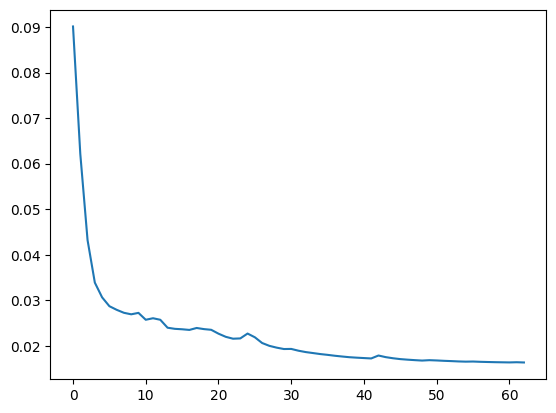

In [ ]:
import joblib
joblib.dump((real_scalers, categorical_scalers), "scalers.pkl")
plt.plot(losses)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', color='blue', marker='o')
plt.plot([i for i in range(len(losses))], [avg_val_loss] * len(losses), label='Validation Loss', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


Model Performance Metrics:
RMSE: 0.04
MAE: 0.03
Total Quantile Loss: 0.03
MAPE: 28.34%


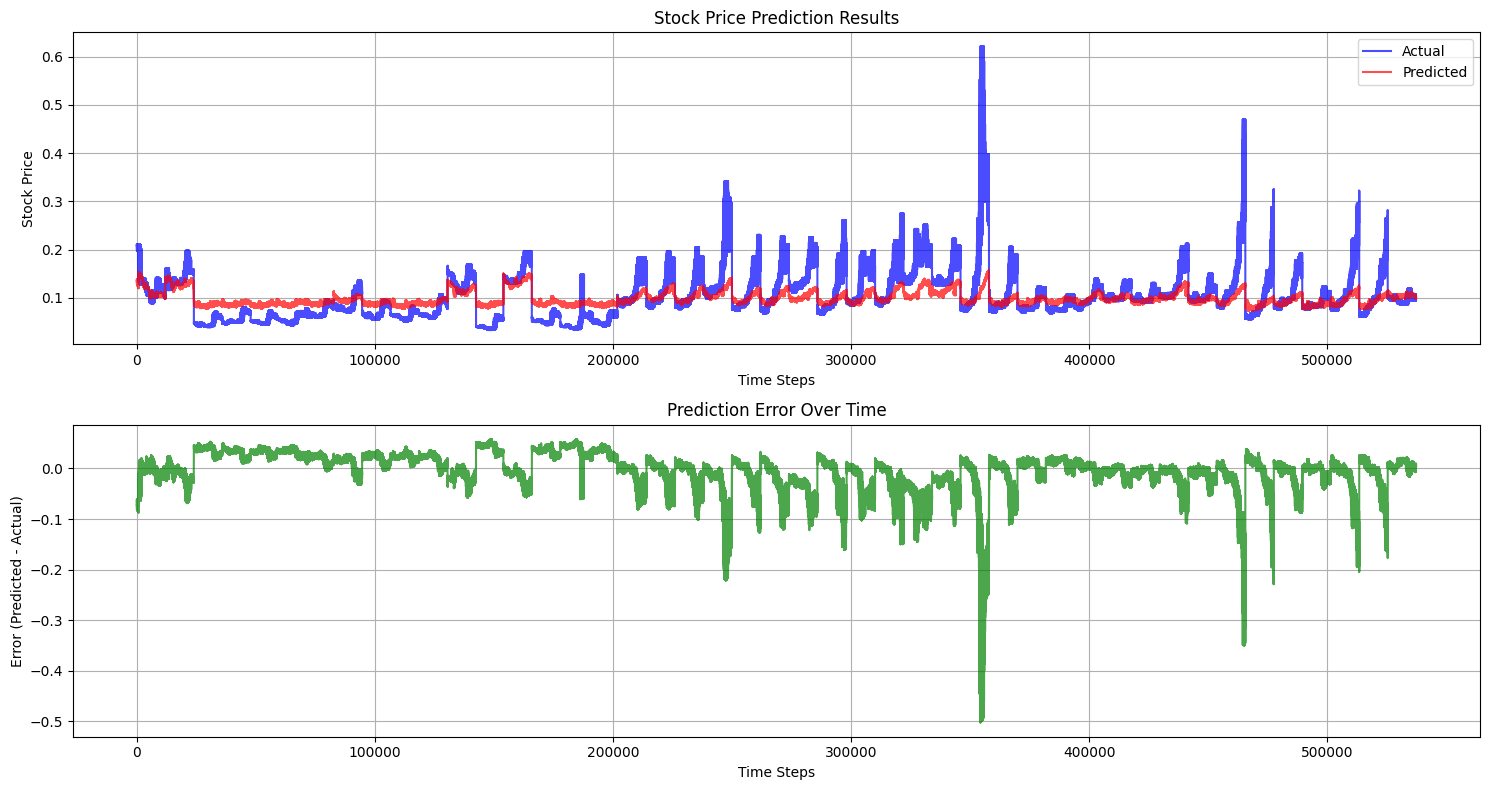

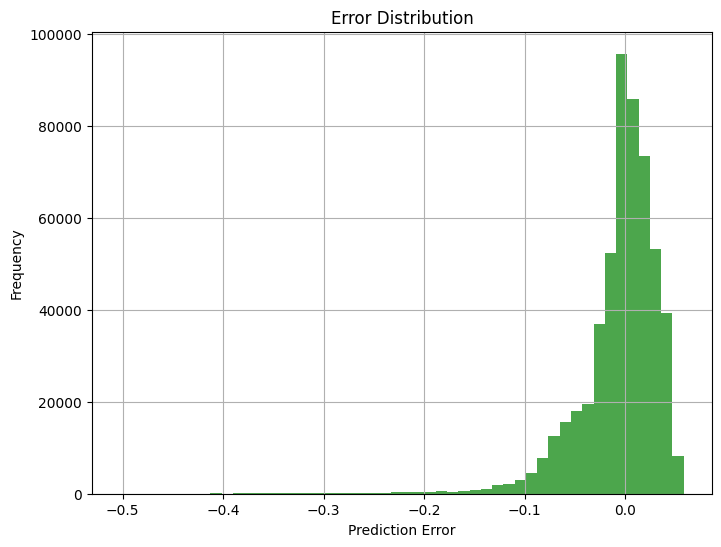

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate_model(model, test_dataloader, DEVICE):
    """
    Evaluate the model on the test data.
    Args:
        model: Trained model.
        test_dataloader: DataLoader for test data.
        device: Device to perform computations (CPU/GPU).
    Returns:
        rmse, mae, mape: Evaluation metrics.
        predictions, actuals: Arrays of predicted and actual values.
    """
    model.eval()  # <-- Proper indentation starts here

    # Store all quantiles
    p10_list, p50_list, p90_list = [], [], []
    actuals_list = []

    with torch.no_grad():
        for batch in test_dataloader:
            # Move batch to device
            batch = {k: v.to(DEVICE) for k, v in batch.items()}

            # Get all quantile predictions
            outputs, _ = model(batch)
            p10_list.append(outputs[:, 0].cpu().numpy())
            p50_list.append(outputs[:, 1].cpu().numpy())
            p90_list.append(outputs[:, 2].cpu().numpy())

            # Get actual values
            actuals = batch['outputs'][:, :, 0].cpu().numpy().flatten()
            actuals_list.append(actuals)

    # Concatenate batches
    p10 = np.concatenate(p10_list)
    p50 = np.concatenate(p50_list)
    p90 = np.concatenate(p90_list)
    actuals = np.concatenate(actuals_list)

    # Calculate MAE/RMSE for median
    rmse = np.sqrt(mean_squared_error(actuals, p50))
    mae = mean_absolute_error(actuals, p50)
    mape = mean_absolute_percentage_error(actuals, p50) * 100

    # Quantile loss calculation
    def quantile_loss(q, y, f):
        e = y - f
        return np.mean(np.maximum(q * e, (q - 1) * e))

    q_loss_10 = quantile_loss(0.1, actuals, p10)
    q_loss_50 = quantile_loss(0.5, actuals, p50)
    q_loss_90 = quantile_loss(0.9, actuals, p90)
    total_q_loss = q_loss_10 + q_loss_50 + q_loss_90

    print("\nModel Performance Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Total Quantile Loss: {total_q_loss:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Return metrics and predictions
    return rmse, mae, mape, p50, actuals, (q_loss_10, q_loss_50, q_loss_90)  # Corrected return statement


def plot_predictions(predictions, actuals, title="Actual vs Predicted Values"):
    """
    Plot actual vs predicted values for visualization.
    Args:
        predictions: Array of predicted values.
        actuals: Array of actual values.
        title: Title of the plot.
    """
    plt.figure(figsize=(15, 8))

    # Main prediction plot
    plt.subplot(2, 1, 1)
    plt.plot(actuals, label='Actual', color='blue', alpha=0.7)
    plt.plot(predictions, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)

    # Error plot
    plt.subplot(2, 1, 2)
    error = predictions - actuals
    plt.plot(error, color='green', alpha=0.7)
    plt.title('Prediction Error Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Error (Predicted - Actual)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional error distribution plot
    plt.figure(figsize=(8, 6))
    plt.hist(error, bins=50, color='green', alpha=0.7)
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Evaluate the model and create plots
rmse, mae, mape, predictions, actuals, quantile_losses = evaluate_model(model, test_dataloader, DEVICE)
plot_predictions(predictions, actuals, "Stock Price Prediction Results")

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
trained_model = torch.load('checkpoint.pth')

<ipython-input-34-7170524d6626>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load('checkpoint.pth')


In [ ]:
def predict_future_prices(model, test_dataloader, real_scalers, categorical_scalers, real_columns, categorical_columns, num_prediction_days=40, symbol_mapping=None):
    model.eval()
    future_predictions = []
    real_scalers, categorical_scalers = joblib.load("scalers.pkl")

    # Get the last batch from test_dataloader for each symbol
    last_known_data = {}
    test_end_date = pd.Timestamp('2025-01-10')  # Set the actual test end date

    with torch.no_grad():
        for batch in test_dataloader:
            batch_size = batch['inputs'].size(0)

            # Get the actual timestamps for the last known data point
            timestamps = batch['time'][:, -1].cpu().numpy()  # Get last timestamp for each sequence
            identifiers = batch['identifier'][:, -1, :].cpu().numpy()

            for i in range(batch_size):
                symbol = int(identifiers[i][0])
                current_timestamp = timestamps[i]

                # Update only if this is the most recent data for this symbol
                if symbol not in last_known_data or current_timestamp > last_known_data[symbol]['last_timestamp']:
                    last_known_data[symbol] = {
                        'inputs': batch['inputs'][i:i+1],
                        'time': batch['time'][i:i+1],
                        'identifier': batch['identifier'][i:i+1],
                        'last_timestamp': current_timestamp
                    }

    # Generate predictions for each symbol
    for symbol, last_data in last_known_data.items():
        try:
            # Start predictions from day after test end date
            print(f"\nGenerating predictions for symbol {symbol} starting from {test_end_date}")

            # Generate future dates (trading days only) starting from test_end_date
            future_dates = pd.date_range(
                start=test_end_date + pd.Timedelta(days=1),
                periods=num_prediction_days,
                freq='B'  # Business days only
            )

            # Make prediction using the last known data
            prediction_batch = {
                'inputs': last_data['inputs'].to(DEVICE),
                'time': last_data['time'].to(DEVICE),
                'identifier': last_data['identifier'].to(DEVICE)
            }

            # Get model predictions
            outputs, _ = model(prediction_batch)
            predictions = outputs.detach().cpu().numpy()

            # Ensure we're using the correct scaler for LTP
            if isinstance(real_scalers['LTP'], str) and real_scalers['LTP'].endswith('.joblib'):
                ltp_scaler = load(real_scalers['LTP'])
            else:
                ltp_scaler = real_scalers['LTP']

            # Unscale predictions
            scaled_predictions = predictions[:, 1].reshape(-1, 1)
            unscaled_predictions = ltp_scaler.inverse_transform(scaled_predictions)

            # Get confidence intervals
            lower_bound = ltp_scaler.inverse_transform(predictions[:, 0].reshape(-1, 1))
            upper_bound = ltp_scaler.inverse_transform(predictions[:, 2].reshape(-1, 1))

            # Decode symbol back to original name using symbol_mapping
            if symbol_mapping is not None:
                original_symbol = symbol_mapping.get(symbol, f"Unknown_Symbol_{symbol}")
            else:
                original_symbol = symbol  # Fallback to numeric symbol if no mapping is provided

            print(f"Processing predictions for symbol: {original_symbol}")

            # Store predictions with dates
            for idx, date in enumerate(future_dates):
                future_predictions.append({
                    'Date': date,
                    'Symbol': original_symbol,
                    'Predicted_LTP': float(unscaled_predictions[idx][0]),
                    'Lower_Bound': float(lower_bound[idx][0]),
                    'Upper_Bound': float(upper_bound[idx][0])
                })
        except Exception as e:
            print(f"Error processing symbol {symbol}: {str(e)}")
            continue

    # Create DataFrame and save to CSV
    predictions_df = pd.DataFrame(future_predictions)
    predictions_df = predictions_df.sort_values(['Symbol', 'Date'])

    # Save predictions to CSV
    filename = f'future_predictions_{datetime.now().strftime("%Y%m%d22213")}.csv'
    predictions_df.to_csv(filename, index=False)
    print(f"\nFuture predictions saved to {filename}")

    return predictions_df

future_predictions = predict_future_prices(
    model=model,
    test_dataloader=test_dataloader,
    real_scalers=real_scalers,
    categorical_scalers=categorical_scalers,
    real_columns=real_columns,
    categorical_columns=categorical_columns,
    num_prediction_days=40,
    symbol_mapping=symbol_mapping  # Pass the symbol mapping here
)


Generating predictions for symbol 0 starting from 2025-01-10 00:00:00
Processing predictions for symbol: NICA

Generating predictions for symbol 1 starting from 2025-01-10 00:00:00
Processing predictions for symbol: EBL

Generating predictions for symbol 2 starting from 2025-01-10 00:00:00
Processing predictions for symbol: CZBIL

Generating predictions for symbol 3 starting from 2025-01-10 00:00:00
Processing predictions for symbol: PCBL

Generating predictions for symbol 4 starting from 2025-01-10 00:00:00
Processing predictions for symbol: GBIME

Generating predictions for symbol 5 starting from 2025-01-10 00:00:00
Processing predictions for symbol: NMB

Generating predictions for symbol 6 starting from 2025-01-10 00:00:00
Processing predictions for symbol: SANIMA

Generating predictions for symbol 7 starting from 2025-01-10 00:00:00
Processing predictions for symbol: SBI

Generating predictions for symbol 8 starting from 2025-01-10 00:00:00
Processing predictions for symbol: SBL

